## <font color=green>__Mobile Payments Fraud Detection Using Arificial Neural Networks__</font>
##### Deep Learning Project by [Yoseph Zuskin](https://www.linkedin.com/in/yoseph-zuskin/), [Krithika Shankar](https://www.linkedin.com/in/krithikashankar/), [Khalid Askar](https://www.linkedin.com/in/khalidaskar/), [Vicky (Xiaoqi) Ma](https://www.linkedin.com/in/vickyma20/), and [Tokey (Mingzhong) Li](https://www.linkedin.com/in/tokeyli/).

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import clone_model
print(tf.__version__)

2.0.0


In [2]:
import pandas as pd
import numpy as np
from matplotlib import style
style.use('seaborn') # use 'dark_background' for dark theme
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

Using TensorFlow backend.


In [3]:
def plot_learningCurve(history, epoch, metric='binary_accuracy'):
    metric_title = metric.replace('_',' ').title()
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history[metric])
    plt.plot(epoch_range, history.history['val_'+metric])
    plt.title('Model '+metric_title)
    plt.ylabel(metric_title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [4]:
def print_confusion_matrix(testset,predictions):
    conmat=pd.DataFrame(confusion_matrix(testset, predictions, labels=[1,0]),
                        index=['Actual Fraud','Actual Non-Fraud'],
                        columns=['Pred Fraud','Pred Non-Fraud'])
    TP=conmat.iloc[0,0]/(conmat.iloc[0,0]+conmat.iloc[0,1])
    FN=conmat.iloc[0,1]/(conmat.iloc[0,0]+conmat.iloc[0,1])
    TN=conmat.iloc[1,1]/(conmat.iloc[1,0]+conmat.iloc[1,1])
    FP=conmat.iloc[1,0]/(conmat.iloc[1,0]+conmat.iloc[1,1])
    print('Percent of true positives: {:.2%}'.format(TP))
    print('Percent of false negatives: {:.2%}'.format(FN))
    print('Percent of true negatives: {:.2%}'.format(TN))
    print('Percent of false positives: {:.2%}'.format(FP))
    return conmat

In [5]:
# below are hyperparameters used for the experiments
batch_bin=32
num_epochs=5
train_pct=0.8
validate_pct=0.2
learning_rate = 1e-3
loss_function='binary_crossentropy'
optimization_function='RMSProp'
metric='binary_accuracy'

### Load and Explore the Simulated Payments Data ([download by clicking here](https://www.kaggle.com/ntnu-testimon/paysim1/download/WFkgBkx3T4g8fI1piSWE%2Fversions%2FaqkdOl5xmdvn6maMN5bg%2Ffiles%2FPS_20174392719_1491204439457_log.csv?datasetVersionNumber=2))

In [6]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
data.shape

(6362620, 11)

In [9]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
data[['step','type','nameOrig','nameDest','isFraud','isFlaggedFraud']].nunique()

step                  743
type                    5
nameOrig          6353307
nameDest          2722362
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [12]:
data.groupby(['type','isFraud','isFlaggedFraud'])[['isFraud']].count().rename(columns={'isFraud':'count'})

count
type     isFraud isFlaggedFraud         
CASH_IN  0       0               1399284
CASH_OUT 0       0               2233384
         1       0                  4116
DEBIT    0       0                 41432
PAYMENT  0       0               2151495
TRANSFER 0       0                528812
         1       0                  4081
                 1                    16

### Data Preprocessing

In [7]:
# one-hot encoding for the categorical 'type' variable
dummies = pd.get_dummies(data['type'])
data2 = pd.concat([data[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
                        'isFraud']],dummies],axis=1)
del dummies
del data

In [8]:
# split data 80-20 across training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(data2.loc[:,data2.columns!='isFraud'],
                                                    data2.loc[:,data2.columns=='isFraud'],
                                                    test_size=validate_pct,train_size=train_pct)

In [9]:
# rescale datasets using StandardScaler on the training datasets
standard = StandardScaler()
standard_x_train = standard.fit_transform(x_train)
standard_x_test = standard.transform(x_test)

In [10]:
# rescale datasets using MinMaxScaler on the training datasets
minmax = MinMaxScaler()
minmax_x_train = minmax.fit_transform(x_train)
minmax_x_test = minmax.transform(x_test)

In [11]:
# reset y variable to numpy array
y_train, y_test = np.array(y_train), np.array(y_test)

In [12]:
# count how many non-fraud and fraud transactions are in the test set
unique,counts = np.unique(y_test,return_counts=True)
dict(zip(unique,counts))

{0: 1270797, 1: 1727}

In [12]:
# separate the data into non-fraud and fraud dataframes
non_fraud = data2[data2['isFraud']==0]
fraud = data2[data2['isFraud']==1]

In [14]:
non_fraud.shape, fraud.shape

((6354407, 12), (8213, 12))

In [13]:
# create a test-train split for the autoencoder using only non-fraud data
train_ae, test_ae = train_test_split(data2, test_size=0.2, random_state=123)
train_ae, valid_ae = train_test_split(train_ae, test_size=0.2, random_state=123)

In [14]:
df_train_0 = train_ae.loc[data2['isFraud'] == 0]
df_train_1 = train_ae.loc[data2['isFraud'] == 1]
df_train_0_x = df_train_0.drop(['isFraud'], axis=1)
df_train_1_x = df_train_1.drop(['isFraud'], axis=1)

df_valid_0 = valid_ae.loc[data2['isFraud'] == 0]
df_valid_1 = valid_ae.loc[data2['isFraud'] == 1]
df_valid_0_x = df_valid_0.drop(['isFraud'], axis=1)
df_valid_1_x = df_valid_1.drop(['isFraud'], axis=1)

df_test_0 = test_ae.loc[data2['isFraud'] == 0]
df_test_1 = test_ae.loc[data2['isFraud'] == 1]
df_test_0_x = df_test_0.drop(['isFraud'], axis=1)
df_test_1_x = df_test_1.drop(['isFraud'], axis=1)

In [15]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(valid_ae.drop(['isFraud'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(test_ae.drop(['isFraud'], axis = 1))

In [16]:
# create a SMOTE balanced version of the standard training dataset
standard_smt = SMOTE()
standard_x_train_sm, standard_y_train_sm = standard_smt.fit_sample(standard_x_train,y_train)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
np.bincount(standard_y_train_sm)

array([5083610, 5083610], dtype=int64)

In [17]:
# create a SMOTE balanced version of the standard training dataset
minmax_smt = SMOTE()
minmax_x_train_sm, minmax_y_train_sm = minmax_smt.fit_sample(minmax_x_train,y_train)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
np.bincount(standard_y_train_sm)

array([5083610, 5083610], dtype=int64)

In [18]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(8213, 12)

In [19]:
rand_balanced_data = fraud.append(non_fraud, ignore_index=True)

In [20]:
rand_balanced_data['isFraud'].value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

In [21]:
# create a randomly balanced datasets for training and testing the feed forward neural netowrk on
rand_x_train,rand_x_test,rand_y_train,rand_y_test=train_test_split(rand_balanced_data.loc[:,non_fraud.columns!='isFraud'],
                                                                   rand_balanced_data.loc[:,non_fraud.columns=='isFraud'],
                                                                   train_size=train_pct,test_size=validate_pct)
rand_y_train=np.array(rand_y_train)
rand_y_test=np.array(rand_y_test)

In [22]:
# rescale datasets using StandardScaler on the training datasets
rand_standard = StandardScaler()
rand_standard_x_train = standard.fit_transform(rand_x_train)
rand_standard_x_test = standard.transform(rand_x_test)

In [23]:
# rescale datasets using MinMaxScaler on the training datasets
rand_minmax = MinMaxScaler()
rand_minmax_x_train = minmax.fit_transform(rand_x_train)
rand_minmax_x_test = minmax.transform(rand_x_test)

### Feedforward Neural Network with Standardized Imbalanced Big Dataset

In [34]:
standardized_imbalanced_ann = Sequential()

standardized_imbalanced_ann.add(InputLayer(input_shape=(11,)))
standardized_imbalanced_ann.add(Dense(64,activation='relu'))
standardized_imbalanced_ann.add(Dropout(0.2))
standardized_imbalanced_ann.add(Dense(32,activation='relu'))
standardized_imbalanced_ann.add(Dropout(0.1))
standardized_imbalanced_ann.add(Dense(1,activation='sigmoid'))

In [35]:
standardized_imbalanced_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [36]:
standardized_imbalanced_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])

In [37]:
filepath="models/standardized-imbalanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_imbalanced_ann = [checkpoint]

In [38]:
standard_imbalaned_ann_fit = standardized_imbalanced_ann.fit(standard_x_train,y_train,
                                                             callbacks=callbacks_list_imbalanced_ann,
                                                             batch_size=batch_bin,epochs=num_epochs,
                                                             validation_split=validate_pct)

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/5
4071840/4072076 [============================>.] - ETA: 0s - loss: 0.0142 - binary_accuracy: 0.9977
Epoch 00001: val_binary_accuracy improved from -inf to 0.99901, saving model to models/standardized-imbalanced-ann-weights-improvement-01-1.00.hdf5
4072076/4072076 [==============================] - 420s 103us/sample - loss: 0.0142 - binary_accuracy: 0.9977 - val_loss: 0.0084 - val_binary_accuracy: 0.9990
Epoch 2/5
4071616/4072076 [============================>.] - ETA: 0s - loss: 0.0205 - binary_accuracy: 0.9968
Epoch 00002: val_binary_accuracy improved from 0.99901 to 0.99906, saving model to models/standardized-imbalanced-ann-weights-improvement-02-1.00.hdf5
4072076/4072076 [==============================] - 369s 91us/sample - loss: 0.0205 - binary_accuracy: 0.9968 - val_loss: 0.0112 - val_binary_accuracy: 0.9991
Epoch 3/5
4071968/4072076 [============================>.] - ETA: 0s - loss: 0.0220 - binary_accuracy: 0.9973


In [39]:
standardized_imbalanced_y_pred = standardized_imbalanced_ann.predict_classes(standard_x_test)

In [40]:
print_confusion_matrix(y_test,standardized_imbalanced_y_pred)

Percent of true positives: 32.03%
Percent of false negatives: 67.97%
Percent of true negatives: 100.00%
Percent of false positives: 0.00%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,525,1114
Actual Non-Fraud,1,1270884


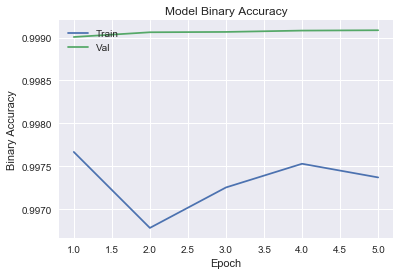

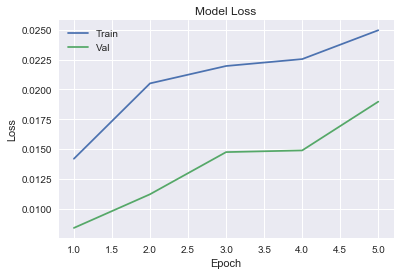

In [41]:
plot_learningCurve(standard_imbalaned_ann_fit,num_epochs)

In [42]:
# save standardized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_imbalaned_ann_fraud_detector.json", "w") as json_file:
    json_file.write(standardized_imbalanced_ann.to_json())
# serialize weights to HDF5
standardized_imbalanced_ann.save_weights("models/standardized_imbalaned_ann_fraud_detector.h5")
del standard_imbalaned_ann_fit
del standardized_imbalanced_y_pred

### Feedforward Neural Network with Normalized Imbalanced Big Dataset

In [43]:
filepath="models/imbalanced-minmax-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_imbalanced_ann = [checkpoint]

In [44]:
minmax_imbalanced_ann = clone_model(standardized_imbalanced_ann)
del standardized_imbalanced_ann
minmax_imbalanced_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])
minamx_imbalaned_ann_fit = minmax_imbalanced_ann.fit(minmax_x_train,y_train,callbacks=callbacks_list_imbalanced_ann,
                                                     batch_size=batch_bin,epochs=num_epochs,validation_split=validate_pct)

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/5
4072000/4072076 [============================>.] - ETA: 0s - loss: 0.0122 - binary_accuracy: 0.9986- ETA: 1s - loss: 0.0122 - binary_acc - ETA: 0s - loss: 0.0122
Epoch 00001: val_binary_accuracy improved from -inf to 0.99872, saving model to models/imbalanced-minmax-ann-weights-improvement-01-1.00.hdf5
4072076/4072076 [==============================] - 445s 109us/sample - loss: 0.0122 - binary_accuracy: 0.9986 - val_loss: 0.0127 - val_binary_accuracy: 0.9987
Epoch 2/5
4071680/4072076 [============================>.] - ETA: 0s - loss: 0.0124 - binary_accuracy: 0.9986
Epoch 00002: val_binary_accuracy did not improve from 0.99872
4072076/4072076 [==============================] - 464s 114us/sample - loss: 0.0124 - binary_accuracy: 0.9986 - val_loss: 0.0108 - val_binary_accuracy: 0.9987
Epoch 3/5
4071840/4072076 [============================>.] - ETA: 0s - loss: 0.0128 - binary_accuracy: 0.9985
Epoch 00003: val_binary_accuracy

In [45]:
normalized_imbalanced_y_pred = minmax_imbalanced_ann.predict_classes(minmax_x_test)

In [46]:
print_confusion_matrix(y_test,normalized_imbalanced_y_pred)

Percent of true positives: 0.00%
Percent of false negatives: 100.00%
Percent of true negatives: 100.00%
Percent of false positives: 0.00%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,0,1639
Actual Non-Fraud,0,1270885


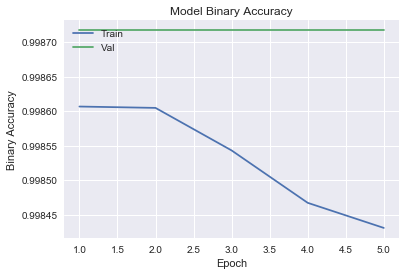

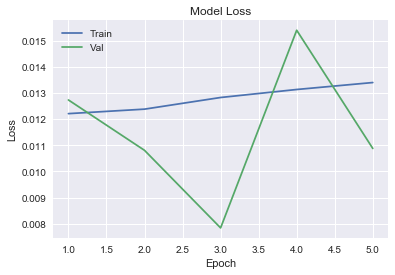

In [47]:
plot_learningCurve(minamx_imbalaned_ann_fit,num_epochs)

In [50]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/normalized-imbalaned-ann_fraud-detector.json", "w") as json_file:
    json_file.write(minmax_imbalanced_ann.to_json())
# serialize weights to HDF5
minmax_imbalanced_ann.save_weights("models/normalized-imbalaned-ann-fraud-detector.h5")
del minmax_imbalanced_ann
del minmax_imbalaned_ann_fit
del normalized_imbalanced_y_pred

### Feedforward with Randomly Balanced Small Dataset

In [51]:
balanced_ann = Sequential()

balanced_ann.add(InputLayer(input_shape=(11,)))
balanced_ann.add(Dense(64,activation='relu'))
balanced_ann.add(Dropout(0.2))
balanced_ann.add(Dense(32,activation='relu'))
balanced_ann.add(Dropout(0.1))
balanced_ann.add(Dense(1,activation='sigmoid'))

In [52]:
balanced_ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [53]:
balanced_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])

In [54]:
filepath="models/balanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_balanced_ann = [checkpoint]

In [55]:
standard_balaned_ann_fit = balanced_ann.fit(rand_standard_x_train,rand_y_train,
                                            callbacks=callbacks_list_balanced_ann,
                                            batch_size=batch_bin,epochs=num_epochs,
                                            validation_split=validate_pct)

Train on 10512 samples, validate on 2628 samples
Epoch 1/5
10080/10512 [===========================>..] - ETA: 0s - loss: 0.3258 - binary_accuracy: 0.8541
Epoch 00001: val_binary_accuracy improved from -inf to 0.88813, saving model to models/balanced-ann-weights-improvement-01-0.89.hdf5
10512/10512 [==============================] - 3s 308us/sample - loss: 0.3239 - binary_accuracy: 0.8549 - val_loss: 0.2354 - val_binary_accuracy: 0.8881
Epoch 2/5
10080/10512 [===========================>..] - ETA: 0s - loss: 0.2564 - binary_accuracy: 0.8879
Epoch 00002: val_binary_accuracy improved from 0.88813 to 0.89536, saving model to models/balanced-ann-weights-improvement-02-0.90.hdf5
10512/10512 [==============================] - 1s 126us/sample - loss: 0.2559 - binary_accuracy: 0.8885 - val_loss: 0.2225 - val_binary_accuracy: 0.8954
Epoch 3/5
10176/10512 [============================>.] - ETA: 0s - loss: 0.2404 - binary_accuracy: 0.8952
Epoch 00003: val_binary_accuracy improved from 0.89536 to 

In [56]:
standardized_balanced_y_pred = balanced_ann.predict_classes(rand_standard_x_test)

In [57]:
print_confusion_matrix(rand_y_test,standardized_balanced_y_pred)

Percent of true positives: 87.45%
Percent of false negatives: 12.55%
Percent of true negatives: 95.24%
Percent of false positives: 4.76%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,1421,204
Actual Non-Fraud,79,1582


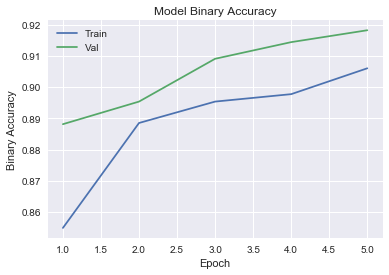

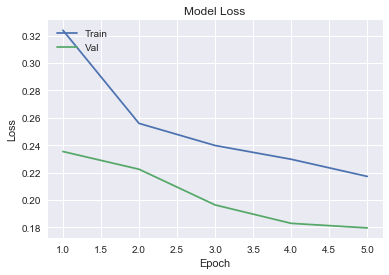

In [58]:
plot_learningCurve(standard_balaned_ann_fit,num_epochs)

In [59]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/standardized-imbalaned-ann-fraud-detector.json", "w") as json_file:
    json_file.write(balanced_ann.to_json())
# serialize weights to HDF5
balanced_ann.save_weights("models/standardized-imbalaned-ann-fraud-detector.h5")
del balanced_ann
del standard_balaned_ann_fit
del standardized_balanced_y_pred

### Feed Forward with SMOTE Big Dataset

In [24]:
standard_smote_ann = Sequential()

standard_smote_ann.add(InputLayer(input_shape=(11,)))
standard_smote_ann.add(Dense(64,activation='relu'))
standard_smote_ann.add(Dropout(0.2))
standard_smote_ann.add(Dense(32,activation='relu'))
standard_smote_ann.add(Dropout(0.1))
standard_smote_ann.add(Dense(1,activation='sigmoid'))

In [25]:
standard_smote_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [26]:
standard_smote_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])

In [32]:
filepath="models/smote-balanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_smote_balanced_ann = [checkpoint]

In [33]:
standardized_smote_fit=standard_smote_ann.fit(standard_x_train_sm,standard_y_train_sm,
                                              callbacks=callbacks_list_smote_balanced_ann,
                                              batch_size=batch_bin,epochs=num_epochs,
                                              validation_split=validate_pct)

Train on 8133776 samples, validate on 2033444 samples
Epoch 1/5
8133536/8133776 [============================>.] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9728
Epoch 00001: val_binary_accuracy improved from -inf to 0.99259, saving model to models/smote-balanced-ann-weights-improvement-01-0.99.hdf5
8133776/8133776 [==============================] - 840s 103us/sample - loss: 0.1010 - binary_accuracy: 0.9728 - val_loss: 0.0918 - val_binary_accuracy: 0.9926
Epoch 2/5
8133344/8133776 [============================>.] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.9784
Epoch 00002: val_binary_accuracy did not improve from 0.99259
8133776/8133776 [==============================] - 865s 106us/sample - loss: 0.1047 - binary_accuracy: 0.9784 - val_loss: 0.0509 - val_binary_accuracy: 0.9923
Epoch 3/5
8133408/8133776 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9804
Epoch 00003: val_binary_accuracy improved from 0.99259 to 0.99327, saving model to models/smote-b

In [34]:
standardized_smote_y_pred = standard_smote_ann.predict_classes(standard_x_test)

In [35]:
print_confusion_matrix(y_test,standardized_smote_y_pred)

Percent of true positives: 98.49%
Percent of false negatives: 1.51%
Percent of true negatives: 98.54%
Percent of false positives: 1.46%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,1701,26
Actual Non-Fraud,18524,1252273


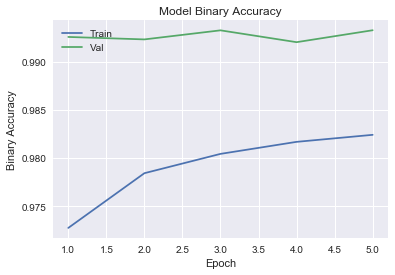

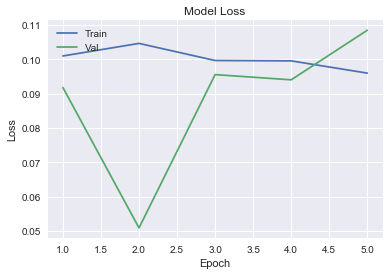

In [36]:
plot_learningCurve(standardized_smote_fit,num_epochs)

In [37]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_smote_balaned_ann_fraud_detector.json", "w") as json_file:
    json_file.write(standard_smote_ann.to_json())
# serialize weights to HDF5
standard_smote_ann.save_weights("models/standardized_smote_balaned_ann_fraud_detector.h5")
del standardized_smote_fit
del standardized_smote_y_pred

In [27]:
filepath="models/normalized-smote-balanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_minmax_smote_balanced_ann = [checkpoint]

In [28]:
minmax_smote_ann=keras.models.clone_model(standard_smote_ann)
del standard_smote_ann
minmax_smote_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])
minmax_smote_fit=minmax_smote_ann.fit(minmax_x_train_sm,minmax_y_train_sm,
                                      callbacks=callbacks_list_minmax_smote_balanced_ann,
                                      batch_size=batch_bin,epochs=num_epochs,validation_split=validate_pct)

Train on 8133587 samples, validate on 2033397 samples
Epoch 1/5
8133152/8133587 [============================>.] - ETA: 0s - loss: 0.1196 - binary_accuracy: 0.9747- ETA: 0s - loss: 0.1196 - binary_accuracy: 
Epoch 00001: val_binary_accuracy improved from -inf to 0.93442, saving model to models/normalized-smote-balanced-ann-weights-improvement-01-0.93.hdf5
8133587/8133587 [==============================] - 1019s 125us/sample - loss: 0.1196 - binary_accuracy: 0.9748 - val_loss: 0.2684 - val_binary_accuracy: 0.9344
Epoch 2/5
8133152/8133587 [============================>.] - ETA: 0s - loss: 0.0784 - binary_accuracy: 0.9853
Epoch 00002: val_binary_accuracy improved from 0.93442 to 0.98975, saving model to models/normalized-smote-balanced-ann-weights-improvement-02-0.99.hdf5
8133587/8133587 [==============================] - 992s 122us/sample - loss: 0.0784 - binary_accuracy: 0.9853 - val_loss: 0.1016 - val_binary_accuracy: 0.9898
Epoch 3/5
8133536/8133587 [============================>.] -

In [29]:
minmax_smote_y_pred = minmax_smote_ann.predict_classes(minmax_x_test)

In [30]:
print_confusion_matrix(y_test,minmax_smote_y_pred)

Percent of true positives: 93.85%
Percent of false negatives: 6.15%
Percent of true negatives: 99.70%
Percent of false positives: 0.30%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,1510,99
Actual Non-Fraud,3765,1267150


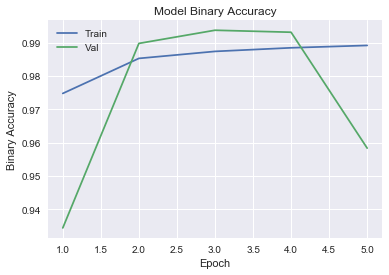

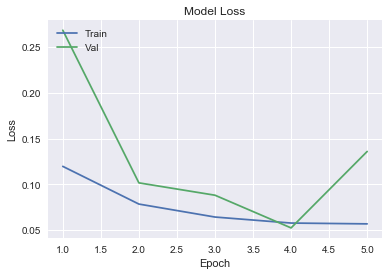

In [32]:
plot_learningCurve(minmax_smote_fit,num_epochs)

In [37]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/normalized-smote-balaned-ann-fraud-detector.json", "w") as json_file:
    json_file.write(minmax_smote_ann.to_json())
# serialize weights to HDF5
minmax_smote_ann.save_weights("models/normalized-smote-balaned-ann-fraud-detector.h5")
del minmax_smote_ann
del minmax_smote_fit
del minmax_smote_y_pred

### Autoencoder Neural Network

In [38]:
autoencoder = Sequential()

autoencoder.add(InputLayer(input_shape=(11,)))
autoencoder.add(Dense(32,activation='relu', activity_regularizer=regularizers.l1(learning_rate)))
autoencoder.add(Dense(6,activation='relu'))
autoencoder.add(Dense(6,activation='relu'))
autoencoder.add(Dense(32,activation='relu'))
autoencoder.add(Dense(11,activation='linear'))

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_7 (Dense)              (None, 11)                363       
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________


In [39]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [40]:
filepath="models/standardized-autoencoder-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list_standard_autoencoder = [checkpoint]

In [41]:
standard_fit_ae = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                                  epochs=5,batch_size=50,shuffle=True,verbose=1,
                                  callbacks=callbacks_list_standard_autoencoder,
                                  validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled)).history

Train on 4066781 samples, validate on 1016735 samples
Epoch 1/5
4066700/4066781 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9844
Epoch 00001: val_accuracy improved from -inf to 0.99437, saving model to models/standardized-autoencoder-weights-improvement-01-0.99.hdf5
4066781/4066781 [==============================] - 318s 78us/sample - loss: 0.0088 - accuracy: 0.9844 - val_loss: 0.0024 - val_accuracy: 0.9944
Epoch 2/5
4066500/4066781 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9949
Epoch 00002: val_accuracy improved from 0.99437 to 0.99482, saving model to models/standardized-autoencoder-weights-improvement-02-0.99.hdf5
4066781/4066781 [==============================] - 319s 78us/sample - loss: 0.0019 - accuracy: 0.9949 - val_loss: 0.0018 - val_accuracy: 0.9948
Epoch 3/5
4066700/4066781 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9960
Epoch 00003: val_accuracy did not improve from 0.99482
4066781/4066781

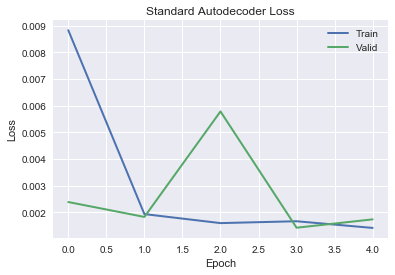

In [44]:
plt.plot(standard_fit_ae['loss'], linewidth=2, label='Train')
plt.plot(standard_fit_ae['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Standard Autodecoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

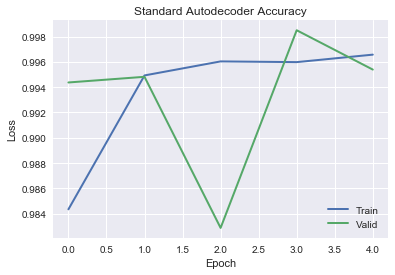

In [45]:
plt.plot(standard_fit_ae['accuracy'], linewidth=2, label='Train')
plt.plot(standard_fit_ae['val_accuracy'], linewidth=2, label='Valid')
plt.legend(loc='lower right')
plt.title('Standard Autodecoder Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

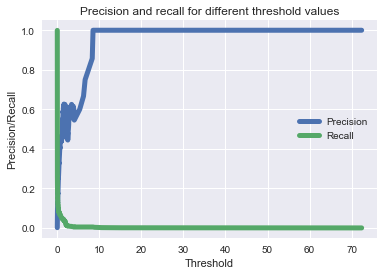

In [46]:
# finding an optimal threshold point for the autoencoder classifier
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': valid_ae['isFraud']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [47]:
precision_rt.T

array([0.00126571, 0.00126473, 0.00126473, ..., 1.        , 1.        ,
       1.        ])

In [48]:
thresh = pd.DataFrame([precision_rt,recall_rt,threshold_rt])

In [49]:
thresh = thresh.T
thresh.columns = ['precision_rt','recall_rt','threshold_rt']

In [50]:
thresh

,precision_rt,recall_rt,threshold_rt
0,0.001266,1.000000,0.000020
1,0.001265,0.999222,0.000020
2,0.001265,0.999222,0.000020
3,0.001265,0.999222,0.000020
4,0.001265,0.999222,0.000020
5,0.001265,0.999222,0.000020
6,0.001265,0.999222,0.000020
7,0.001265,0.999222,0.000020
8,0.001265,0.999222,0.000020
9,0.001265,0.999222,0.000020


In [51]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_ae['isFraud']})
error_df_test = error_df_test.reset_index()

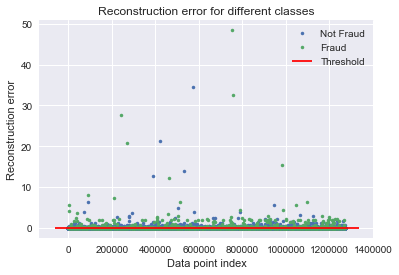

In [52]:
# visualize the classification results from the autoecoder given the following threshold
threshold_fixed = 0.0468
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Not Fraud")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [53]:
# convert autoencoder reconstruction results to binary classifications using threshold point
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [54]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

In [55]:
print_confusion_matrix(error_df.True_class,pred_y)

Percent of true positives: 20.31%
Percent of false negatives: 79.69%
Percent of true negatives: 99.75%
Percent of false positives: 0.25%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,261,1024
Actual Non-Fraud,2497,1014238


In [57]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_autoencoder.json", "w") as json_file:
    json_file.write(autoencoder.to_json())
# serialize weights to HDF5
autoencoder.save_weights("models/standardized_autoencoder.h5")